In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../zeolite-property-prediction/code/")
sys.path.insert(0, "../zeolite-property-prediction/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm


from models.equivariant_mpnn import MPNN, MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [2]:
import matplotlib as mpl

In [3]:
plt.rc('font', family='serif',)


In [4]:
from matplotlib import rc

In [59]:
data = get_zeolite('MOR', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MOR')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [6]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)

In [7]:
trainX = trainloader.dataset.X.sum((1,2))[:,None].numpy()
trainy = trainloader.dataset.y[:,None].numpy()
testX = testloader.dataset.X.sum((1,2))[:,None].numpy()
testy = testloader.dataset.y[:,None].numpy()

In [8]:
from sklearn.linear_model import LinearRegression as LR

In [9]:
lr = LR()
lr.fit(trainX, trainy)

LinearRegression()

In [10]:
yhat = lr.predict(testX)

In [11]:
yhat.shape, testy.shape

((500, 1), (500, 1))

In [12]:
lr_mse, lr_mae = np.mean((testy - yhat)**2), np.mean(np.abs(testy - yhat))

In [13]:
lr_mse, lr_mae

(6.583005794436991, 1.9449891450851584)

In [14]:
title_size=7.5
label_size=7

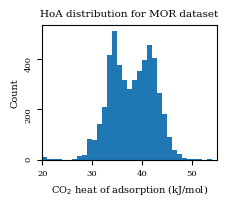

In [15]:
plt.figure(figsize=(2.25,1.75))
plt.hist(hoa, bins=np.arange(20,55,1))
plt.xlabel('CO$_2$ heat of adsorption (kJ/mol)', fontsize=label_size)
plt.ylabel('Count', fontsize=label_size)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation='vertical')
plt.title('HoA distribution for MOR dataset', fontsize=title_size)
plt.xlim(20,55)
plt.savefig('figures/datadist_mor.pdf', dpi=1200, bbox_inches="tight")
tikzz = plt.xticks()[0]

In [16]:
hoa_x = np.tile(np.linspace(20,55,35)[:,None], (1,12))
hoa_y = np.tile(np.arange(0,12,1)[None], (hoa_x.shape[0],1))


In [17]:
zi = np.zeros((len(hoa_x),12))

for i in range(len(atoms)):
    
    curr_h = hoa[i]
    
    n_als = atoms[i].sum() - 1
    if n_als == -1:
        n_als = 0
              
    for _x in range(0,len(hoa_x)-1):
        
        if hoa_x[_x, n_als] < curr_h <= hoa_x[_x+1, n_als]:
            zi[_x, n_als] += 1

In [18]:
zi = zi/zi.sum(0)[None]

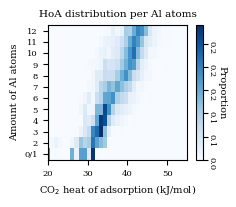

In [19]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
CS = plt.pcolormesh(hoa_x, hoa_y, zi,
                  vmax=zi.max(), vmin=0, cmap='Blues')

plt.xlabel(f"CO$_2$ heat of adsorption (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Amount of Al atoms", fontsize=label_size)
plt.title("HoA distribution per Al atoms", fontsize=title_size)
cbar = plt.colorbar()
plt.yticks(np.arange(0.,12,1), ['0/1'] + np.arange(2,13,1).tolist(), fontsize=6, rotation='horizontal')
plt.xticks(tikzz)
plt.xticks(fontsize=6)
plt.xlim(20,55)
plt.ylim(-0.5,11.5)
cbar.ax.tick_params(labelsize=6, rotation=270,pad=0)
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label('Proportion', rotation=270, fontsize=label_size)
plt.savefig('figures/aldist_mor.pdf', dpi=1200, bbox_inches="tight")

In [20]:
hoa_x.shape, hoa_y.shape, zi.shape

((35, 12), (35, 12), (35, 12))

In [21]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True).to('cuda')

In [22]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [23]:
_mae_p = []
_mse_p = []


for j in tqdm(range(1,11)):

    mpnn.load_state_dict(torch.load(f'model_data_random/MOR/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn.predict(testloader)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    _mae_p.append(_mae)
    _mse_p.append(_mse)


mae_p  = np.mean(_mae_p)
mse_p = np.mean(_mse_p)


mae_p_ci = get_95_CI(_mae_p)
mse_p_ci = get_95_CI(_mse_p)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.06it/s]


In [24]:
best_idx = np.argmin(_mae_p)
mpnn.load_state_dict(torch.load(f'model_data_random/MOR/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn.predict(testloader)

In [72]:
_X, _bonds, _X_p, _bonds_sp, _bonds_ps, _y = next(iter(testloader))

In [73]:
pred, hidden = mpnn.forward(_X.float().cuda(), _bonds.float().cuda(), _X_p.float().cuda(), _bonds_sp.float().cuda(), _bonds_ps.float().cuda(), return_hidden=True)

In [74]:
hid = hidden[0].detach().cpu()

In [75]:
hid = hid.abs().sum(1).numpy()

In [78]:
hid

array([156.80916 , 153.51634 ,  68.67219 ,  62.806957,  22.784391,
        21.334812,  22.65324 ,  23.716782,  44.830017,  39.948647,
        49.29442 ,  51.359108,  24.696802,  13.966723,  13.890806,
        27.55384 ], dtype=float32)

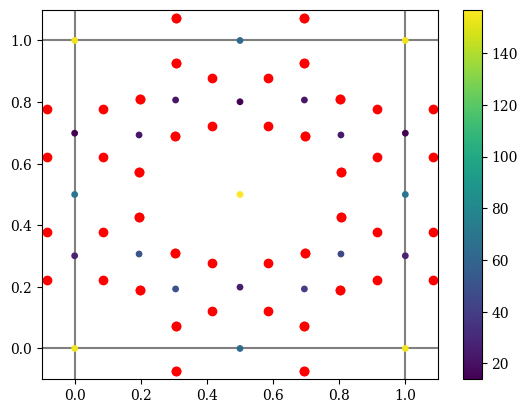

In [88]:

plt.vlines([0,1], -1, 2, color='black', zorder=-200, alpha=0.5)
plt.hlines([0,1], -1, 2, color='black', zorder=-200, alpha=0.5)


plt.scatter(X[:,0], X[:,1], c= 'r')
plt.scatter(X[:,0]+1, X[:,1]+1, c= 'r')
plt.scatter(X[:,0]+1, X[:,1], c= 'r')
plt.scatter(X[:,0], X[:,1]+1, c= 'r')


plt.scatter(X[:,0]-1, X[:,1]-1, c= 'r')
plt.scatter(X[:,0]-1, X[:,1], c= 'r')
plt.scatter(X[:,0], X[:,1]-1, c= 'r')

plt.scatter(X_pore[:,0], X_pore[:,1], c= hid, s=15)
plt.scatter(X_pore[:,0]+1, X_pore[:,1]+1, c= hid, s=15)
plt.scatter(X_pore[:,0]+1, X_pore[:,1], c= hid, s=15)
plt.scatter(X_pore[:,0], X_pore[:,1]+1, c= hid, s=15)


for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        pass

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.colorbar()

In [81]:
hidden[0]

tensor([[-1.0400e-02,  2.6376e+01, -1.8811e-01, -9.6198e-02, -1.2540e-01,
          5.5861e+00,  1.4925e+01, -2.3626e-01,  3.1855e+00, -1.0106e-03,
         -1.9091e-01, -2.0032e-01,  2.0198e+01, -2.1612e-02, -3.7148e-01,
          1.8951e+01, -1.6085e-01, -3.3693e-02, -3.3584e-01, -2.2447e-01,
          3.7135e+01,  1.5571e+01, -2.4498e-02,  1.2661e+01],
        [-8.4321e-03,  2.5933e+01, -1.8866e-01, -7.6087e-02, -1.2236e-01,
          5.1124e+00,  1.4129e+01, -2.2542e-01,  2.5098e+00, -5.0644e-03,
         -1.8451e-01, -1.8152e-01,  2.0228e+01, -3.0288e-02, -3.6221e-01,
          1.8348e+01, -1.5699e-01, -3.3142e-02, -3.2931e-01, -2.1536e-01,
          3.6864e+01,  1.5928e+01, -3.3912e-02,  1.2311e+01],
        [ 9.8908e-01,  1.2972e+01, -1.3309e-01, -1.7444e-02, -4.2409e-02,
          4.5719e+00,  3.6037e+00, -5.8306e-02, -1.0840e-02,  7.6119e-01,
         -3.0052e-02, -1.6965e-02,  1.0704e+01, -3.6853e-02, -1.1881e-01,
          4.0448e+00, -9.6868e-02, -5.3230e-02, -2.0115e-01, -

In [69]:
from scipy.interpolate import griddata

In [28]:
y_pred.min(), y_pred.max(), y_true.min(), y_true.max()

(tensor(19.6512), tensor(47.6126), tensor(20.8601), tensor(48.3556))

In [100]:
Z = torch.ones_like(y_pred)

In [29]:
nn = 60
xmin = 20
xmax = 50
xi = np.linspace(xmin, xmax, nn)
yi = np.linspace(xmin, xmax, nn)

In [30]:
#xi.shape, yi.shape, xi, yi

In [31]:
zi = np.zeros((nn,nn))

for i in range(len(y_pred)):
    
    curr_p = y_pred[i].item()
    curr_t = y_true[i].item()
    
    for _x in range(0,nn-1):
        
        if xi[_x] < curr_p <= xi[_x+1]:
            
            for _y in range(0,nn-1):
                
                if yi[_y] < curr_t <= xi[_y+1]:
                    
                    zi[_x,_y] += 1

In [32]:
n_colors = int(zi.max())

C:\Users\20175552\AppData\Local\Temp\ipykernel_24820\1783921490.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', n_colors+1)


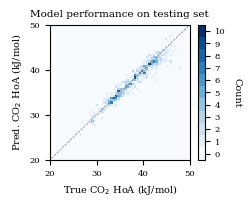

In [33]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
cmap = plt.cm.get_cmap('Blues', n_colors+1)
CS = plt.pcolormesh(xi, yi, zi,
                  vmax=zi.max(), vmin=0, cmap=cmap)
plt.xlabel(f"True CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Pred. CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.title("Model performance on testing set", fontsize=title_size)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 12
cbar.set_label('Count', rotation=270, fontsize=label_size)
cbar.ax.get_yaxis().set_ticks(np.arange(n_colors/(2*(n_colors+1)), n_colors, n_colors/(n_colors+1)), np.arange(n_colors+1) )
cbar.ax.tick_params(labelsize=6)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)

#plt.savefig('figures/truepred.svg', dpi=1200, bbox_inches="tight")
plt.savefig('figures/truepred_mor_int.pdf', dpi=1200, bbox_inches="tight")